**Задание для выполнения в классе:**
1. Напишите функцию, которая принимает на вход списки меток звуков, слов и синтагм и возвращает список словарей, отражающих иерархическую структуру высказывания.

    Каждый словарь в списке &ndash; это синтагма. У него должны быть ключи:  
    * `"model"`: интонационная модель;  
    * `"start"`: время начала (в отсчётах);  
    * `"end"`: время конца (в отсчётах);  
    * `"nucleus"`: индекс слова, содержащего интонационный центр;  
    * `"words"`: список слов.

    Каждое слово &ndash; это тоже словарь. У него должны быть ключи:  
    * `"word"`: слово в орфографической записи;  
    * `"start"`: время начала (в отсчётах);  
    * `"end"`: время конца (в отсчётах);  
    * `"is_stressed"`: является ли слово ударным (`True` или `False`);  
    * `"is_nucleus"`: является ли слово интонационным центром (`True` или `False`);  
    * `"is_prominent"`: несёт ли слово дополнительную интонационную выделенность (`True` или `False`);  
    * `"stressed_vowel"`: индекс ударного гласного;  
    * `"sounds"`: список звуков.

    Каждый звук &ndash; это тоже словарь. У него должны быть ключи:  
    * `"sound"`: обозначение аллофона;  
    * `"start"`: время начала (в отсчётах);  
    * `"end"`: время конца (в отсчётах).

    Условные обозначения:  
    * метки звуков находятся на уровне B1;
    * метки слов находятся на уровне Y1;
    * метки синтгам находятся на уровне R2;
    * на уровне синтагм метки пауз имеют названия вида pX, где X от 1 до 6;
    * по умолчанию интонационный центр находится на последнем слове синтагмы;
    * если это не так, то перед центром стоит символ [-];
    * просодически выделеные слова отмечены знаком [+];
    * ударные гласные заканчиваются на символ 0;


In [ ]:
!wget https://pkholyavin.github.io/mastersprogramming/cta0001-0010.zip

--2024-05-20 09:50:35--  https://pkholyavin.github.io/mastersprogramming/cta0001-0010.zip
Resolving pkholyavin.github.io (pkholyavin.github.io)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to pkholyavin.github.io (pkholyavin.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3237448 (3.1M) [application/zip]
Saving to: ‘cta0001-0010.zip’

cta0001-0010.zip    100%[===================>]   3.09M  --.-KB/s    in 0.02s   

2024-05-20 09:50:35 (182 MB/s) - ‘cta0001-0010.zip’ saved [3237448/3237448]



In [ ]:
!unzip -q cta0001-0010.zip

In [ ]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]
code_to_level = {i: j for i, j in zip(level_codes, levels)}
level_to_code = {j: i for i, j in zip(level_codes, levels)}


def detect_encoding(file_path):
    encoding = "utf-8"
    try:
        l = open(file_path, 'r', encoding="utf-8").read()
        if l.startswith("\ufeff"):  # т.н. byte order mark
            encoding = "utf-8-sig"
    except UnicodeDecodeError:
        try:
            open(file_path, 'r', encoding="utf-16").read()
            encoding = "utf-16"
        except UnicodeError:
            encoding = "cp1251"
    return encoding


def read_seg(filename: str, encoding: str = "utf-8-sig") -> tuple[dict, list[dict]]:
    with open(filename, encoding=encoding) as f:
        lines = [line.strip() for line in f.readlines()]

    # найдём границы секций в списке строк:
    header_start = lines.index("[PARAMETERS]") + 1
    data_start = lines.index("[LABELS]") + 1

    # прочитаем параметры
    params = {}
    for line in lines[header_start:data_start - 1]:
        key, value = line.split("=")
        params[key] = int(value)

    # прочитаем метки
    labels = []
    for line in lines[data_start:]:
        # если в строке нет запятых, значит, это не метка и метки закончились
        if line.count(",") < 2:
            break
        pos, level, name = line.split(",", maxsplit=2)
        label = {
            "position": int(pos) // params["BYTE_PER_SAMPLE"] // params["N_CHANNEL"],
            "level": code_to_level[int(level)],
            "name": name
        }
        labels.append(label)
    return params, labels

In [ ]:
def get_syntagma_dict(sound_labels: list[dict], word_labels: list[dict], synt_labels: list[dict]) -> list[dict]:
    synt_list = []
    for label_s, label_e in zip(synt_labels, synt_labels[1:]):
        if label_s["name"].startswith("p"): # если это пауза
            continue
        synt_dict = {
            "model": label_s["name"],
            "start": label_s["position"],
            "end": label_e["position"],
            "nucleus": None,
            "words": []
        }
        synt_list.append(synt_dict)
        for word_s, word_e in zip(word_labels, word_labels[1:]):
            if not (label_s["position"] <= word_s["position"] < label_e["position"]):
                continue
            word_dict = {
                "word": word_s["name"],
                "start": word_s["position"],
                "end": word_e["position"],
                "is_stressed": False,
                "is_nucleus": word_s["name"].startswith("[-]"),
                "is_prominent": word_s["name"].startswith("[+]"),
                "stressed_vowel": None,
                "sounds": []
            }
            synt_dict["words"].append(word_dict)
            if word_dict["is_nucleus"]:
                synt_dict["nucleus"] = len(synt_dict["words"]) - 1
            for sound_s, sound_e in zip(sound_labels, sound_labels[1:]):
                if not (word_s["position"] <= sound_s["position"] < word_e["position"]):
                    continue
                sound_dict = {
                    "sound": sound_s["name"],
                    "start": sound_s["position"],
                    "end": sound_e["position"]
                }
                word_dict["sounds"].append(sound_dict)
                if sound_dict["sound"].endswith("0"):
                    word_dict["stressed_vowel"] = len(word_dict["sounds"]) - 1
                    word_dict["is_stressed"] = True
        # если по пути мы не встретили ядро синтагмы, то это последнее ударное слово
        # просто переберём все найденные слова задом наперёд
        # на первом встретившемся поставим ядро
        # и на этом закончим цикл
        if synt_dict["nucleus"] is None:
            for i, word in enumerate(synt_dict["words"][::-1]):
                if word["is_stressed"]:
                    synt_dict["nucleus"] = len(synt_dict["words"]) - i - 1
                    word["is_nucleus"] = True
                    break
    return synt_list

In [ ]:
def get_labels(file_name) -> tuple[list[dict]]:
    params, sound_labels = read_seg(file_name.split(".")[0] + ".seg_B1")
    _, word_labels = read_seg(file_name.split(".")[0] + ".seg_Y1", encoding=detect_encoding(file_name.split(".")[0] + ".seg_Y1"))
    _, synt_labels = read_seg(file_name.split(".")[0] + ".seg_R2")
    return params, sound_labels, word_labels, synt_labels

In [ ]:
_, sound_labels, word_labels, synt_labels = get_labels("cta0001-0010/cta0009.seg_B1")
get_syntagma_dict(sound_labels, word_labels, synt_labels)

[{'model': '12',
  'start': 0,
  'end': 13170,
  'nucleus': 1,
  'words': [{'word': 'и',
    'start': 0,
    'end': 2751,
    'is_stressed': False,
    'is_nucleus': False,
    'is_prominent': False,
    'stressed_vowel': None,
    'sounds': [{'sound': 'i1', 'start': 0, 'end': 2751}]},
   {'word': '[-]то',
    'start': 2751,
    'end': 8220,
    'is_stressed': True,
    'is_nucleus': True,
    'is_prominent': False,
    'stressed_vowel': 1,
    'sounds': [{'sound': 't', 'start': 2751, 'end': 5842},
     {'sound': 'o0', 'start': 5842, 'end': 8220}]},
   {'word': 'лишь',
    'start': 8220,
    'end': 13170,
    'is_stressed': False,
    'is_nucleus': False,
    'is_prominent': False,
    'stressed_vowel': None,
    'sounds': [{'sound': "l'", 'start': 8220, 'end': 9422},
     {'sound': 'i4', 'start': 9422, 'end': 10906},
     {'sound': 'sh', 'start': 10906, 'end': 13170}]}]},
 {'model': '02',
  'start': 13170,
  'end': 42031,
  'nucleus': 2,
  'words': [{'word': 'в',
    'start': 13170,
 

2. Напишите функцию, которая принимает на вход имя звукового файла и сопутствующих меток и изображает график мелодической деклинации, т.е. максимумы ЧОТ в ударном гласном каждого слова, для каждой синтагмы. ЧОТ вычислите при помощи `parselmouth`.

In [ ]:
!pip install praat-parselmouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 73.7 MB/s eta 0:00:00


In [ ]:
import parselmouth
import matplotlib.pyplot as plt

In [ ]:
def plot_declination(filename: str) -> None:
    params, *labels = get_labels(filename)
    fs = params["SAMPLING_FREQ"]
    sound = parselmouth.praat.call("Read Sound from raw 16-bit Little Endian file", filename)
    sound.override_sampling_frequency(fs)
    step, min_f0, max_f0 = 0.01, 75, 350  # s, Hz, Hz
    pitch = sound.to_pitch()
    synt_list = get_syntagma_dict(*labels)
    for synt in synt_list:
        max_f0 = []
        ctr = 0
        buffer = ""
        for word in synt["words"]:
            if not word["is_stressed"]:
                buffer += (" " + word["word"])  # будем сохранять все клитики, чтобы приписывать их перед следующим ударным словом
                continue
            vowel = word["sounds"][word["stressed_vowel"]]
            start_time = vowel["start"] / fs
            end_time = vowel["end"] / fs
            max_value = parselmouth.praat.call(pitch, "Get maximum", start_time, end_time, "Hertz", "Parabolic")
            max_f0.append(max_value)
            plt.text(ctr, max_value, buffer + " " + word["word"])  # напишем слово на графике возле соответствующей ему точки
            buffer = ""
            ctr += 1
        plt.plot(max_f0, "o-", label=synt["model"])
    plt.legend()
    plt.show()

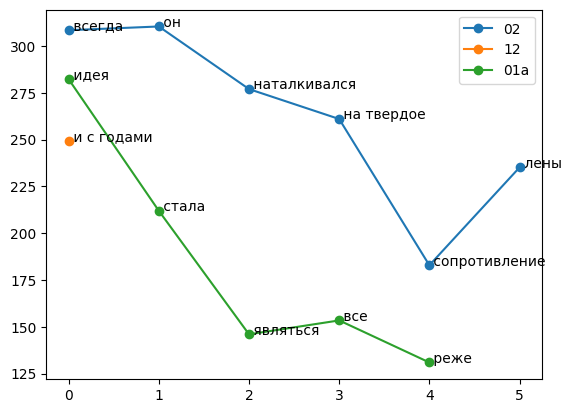

In [ ]:
plot_declination("cta0001-0010/cta0008.sbl")

3*. Напишите программу, которая обрабатывает все файлы в архиве и рисует N графиков (по количеству разных интонационных моделей, встретившихся в материале), на каждом из которых изображены все интонационные кривые внутри ядерного гласного из всех синтагм, оформленных этой моделью.

**Домашнее задание:** проделайте всё то же самое, но используйте метки G1 как источник информации о ЧОТ. Сравните полученные данные.